In [234]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from xgboost import XGBRegressor


In [235]:
# Load Berkeley Earth
berkeley_ds = xr.open_dataset(r"C:\Users\Syeed\OneDrive\Desktop\Capstone 2\Land_and_Ocean_LatLong1.nc", engine="netcdf4")
berkeley_temp = berkeley_ds["temperature"].mean(dim=["latitude", "longitude"], skipna=True)
berkeley_df = berkeley_temp.to_dataframe().reset_index()
berkeley_df["ds"] = pd.to_datetime((berkeley_df["time"] - 1850) * 365.25, origin="1850-01-01", unit="D")
berkeley_df = berkeley_df.set_index("ds").resample("Y").mean().reset_index()
berkeley_df["source"] = "Berkeley"
berkeley_df["Year"] = berkeley_df["ds"].dt.year
berkeley_df = berkeley_df.rename(columns={"temperature": "y"})

# Load HadCRUT
hadcrut_ds = xr.open_dataset(r"C:\Users\Syeed\OneDrive\Desktop\Capstone 2\HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc", engine="netcdf4")
hadcrut_temp = hadcrut_ds["tas_mean"].mean(dim=["latitude", "longitude"], skipna=True)
hadcrut_df = hadcrut_temp.to_dataframe().reset_index()
hadcrut_df = hadcrut_df.set_index("time").resample("Y").mean().reset_index()
hadcrut_df["source"] = "HadCRUT"
hadcrut_df["Year"] = hadcrut_df["time"].dt.year
hadcrut_df = hadcrut_df.rename(columns={"time": "ds", "tas_mean": "y"})

# Filter to overlapping years
common_years = np.intersect1d(berkeley_df["Year"].unique(), hadcrut_df["Year"].unique())
berkeley_df = berkeley_df[berkeley_df["Year"].isin(common_years)]
hadcrut_df = hadcrut_df[hadcrut_df["Year"].isin(common_years)]

# Merge datasets
merged_df = pd.concat([berkeley_df, hadcrut_df]).sort_values("ds").reset_index(drop=True)


In [236]:
merged_df["Decade"] = (merged_df["Year"] // 10) * 10

# Lagged and rolling features
merged_df["TempLag1"] = merged_df.groupby("source")["y"].shift(1)
merged_df["TempLag2"] = merged_df.groupby("source")["y"].shift(2)
merged_df["RollingMean5"] = merged_df.groupby("source")["y"].transform(lambda x: x.rolling(5).mean())
merged_df["RollingStd5"] = merged_df.groupby("source")["y"].transform(lambda x: x.rolling(5).std())
merged_df["RollingMean5_Lag1"] = merged_df.groupby("source")["RollingMean5"].shift(1)
merged_df["RollingStd5_Lag1"] = merged_df.groupby("source")["RollingStd5"].shift(1)

# Smoothed lag
merged_df["SmoothedLag5"] = merged_df.groupby("source")["y"].transform(lambda x: x.rolling(5).mean().shift(1))

# Normalize features
scaler = StandardScaler()
merged_df["Year_Norm"] = scaler.fit_transform(merged_df[["Year"]])
merged_df["SmoothedLag5_Norm"] = scaler.fit_transform(merged_df[["SmoothedLag5"]])

# Drop rows missing engineered features
required_cols = [
    "TempLag1", "TempLag2",
    "RollingMean5", "RollingStd5",
    "RollingMean5_Lag1", "RollingStd5_Lag1",
    "SmoothedLag5", "SmoothedLag5_Norm"
]
merged_df = merged_df.dropna(subset=required_cols).reset_index(drop=True)


In [237]:
# Feature engineering: create lagged and rolling features
merged_df["Decade"] = (merged_df["Year"] // 10) * 10
merged_df["TempLag1"] = merged_df.groupby("source")["y"].shift(1)
merged_df["TempLag2"] = merged_df.groupby("source")["y"].shift(2)
merged_df["RollingMean5"] = merged_df.groupby("source")["y"].transform(lambda x: x.rolling(5).mean())
merged_df["RollingStd5"] = merged_df.groupby("source")["y"].transform(lambda x: x.rolling(5).std())
merged_df["RollingMean5_Lag1"] = merged_df.groupby("source")["RollingMean5"].shift(1)
merged_df["RollingStd5_Lag1"] = merged_df.groupby("source")["RollingStd5"].shift(1)
merged_df["SmoothedLag5"] = merged_df.groupby("source")["y"].transform(lambda x: x.rolling(5).mean().shift(1))

# Normalize selected features
scaler = StandardScaler()
merged_df["Year_Norm"] = scaler.fit_transform(merged_df[["Year"]])
merged_df["SmoothedLag5_Norm"] = scaler.fit_transform(merged_df[["SmoothedLag5"]])

# Drop rows with missing engineered features
required = ["TempLag1", "TempLag2", "RollingMean5", "RollingStd5",
            "RollingMean5_Lag1", "RollingStd5_Lag1", "SmoothedLag5", "SmoothedLag5_Norm"]
merged_df = merged_df.dropna(subset=required).reset_index(drop=True)

# Define features and target
features = ["TempLag1", "TempLag2", "RollingMean5", "RollingStd5",
            "RollingMean5_Lag1", "RollingStd5_Lag1", "Year_Norm", "SmoothedLag5_Norm"]
target = "y"
X = merged_df[features]
y = merged_df[target]

# Train HistGradientBoosting and RandomForest
hist_model = HistGradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
hist_model.fit(X, y)
rf_model.fit(X, y)
merged_df["HistGB_Predicted"] = hist_model.predict(X)
merged_df["RF_Predicted"] = rf_model.predict(X)

# Train Prophet and merge predictions
prophet_input = merged_df.groupby("Year")[["ds", "y"]].mean().reset_index()
prophet_model = Prophet(yearly_seasonality=False, daily_seasonality=False)
prophet_model.fit(prophet_input[["ds", "y"]])
future_df = pd.DataFrame({"ds": pd.to_datetime([f"{yr}-12-31" for yr in merged_df["Year"].unique()])})
forecast = prophet_model.predict(future_df)
forecast["Year"] = forecast["ds"].dt.year
prophet_preds = forecast[["Year", "yhat"]].rename(columns={"yhat": "Prophet_Predicted"})
merged_df = pd.merge(merged_df, prophet_preds, on="Year", how="left")
merged_df["Prophet_Predicted"] = merged_df["Prophet_Predicted"].fillna(merged_df["y"])

# Cross-validated XGBoost
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_preds = np.zeros(len(X))
for train_idx, val_idx in kf.split(X):
    xgb_model = XGBRegressor(n_estimators=100, tree_method="hist", random_state=42)
    xgb_model.fit(X.iloc[train_idx], y.iloc[train_idx])
    cv_preds[val_idx] = xgb_model.predict(X.iloc[val_idx])
merged_df["XGB_CV"] = cv_preds

# Compute R² scores for weighting
r2_scores = {
    "HistGB": r2_score(y, merged_df["HistGB_Predicted"]),
    "RF": r2_score(y, merged_df["RF_Predicted"]),
    "Prophet": r2_score(y, merged_df["Prophet_Predicted"]),
    "XGB": r2_score(y, merged_df["XGB_CV"])
}
total_r2 = sum(r2_scores.values())
weights = {k: v / total_r2 for k, v in r2_scores.items()}

# Weighted ensemble prediction
merged_df["ModelAvg"] = (
    weights["HistGB"] * merged_df["HistGB_Predicted"] +
    weights["RF"] * merged_df["RF_Predicted"] +
    weights["Prophet"] * merged_df["Prophet_Predicted"] +
    weights["XGB"] * merged_df["XGB_CV"]
)


02:55:19 - cmdstanpy - INFO - Chain [1] start processing
02:55:19 - cmdstanpy - INFO - Chain [1] done processing


In [238]:
# # Diagnostic Block: Model Integration & Performance Check

# from sklearn.metrics import r2_score, mean_squared_error

# # Step 1: Check for expected columns
# expected_cols = [
#     "HistGB_Predicted",
#     "RF_Predicted",
#     "Prophet_Predicted",
#     "XGB_CV",
#     "ModelAvg"
# ]

# missing = [col for col in expected_cols if col not in merged_df.columns]
# if missing:
#     print("Missing columns:", missing)
# else:
#     print("All model prediction columns are present.")

# # Step 2: Check for NaNs
# nan_counts = merged_df[expected_cols].isna().sum()
# print("\nNaN counts per column:")
# print(nan_counts)

# if nan_counts.sum() == 0:
#     print("No missing predictions — all models ran successfully.")
# else:
#     print("Some predictions contain NaNs. Investigate upstream.")

# # Step 3: Accuracy snapshot
# print("\nModel Performance:")
# for col in expected_cols[:-1]:  # Skip ModelAvg
#     r2 = r2_score(merged_df["y"], merged_df[col])
#     rmse = np.sqrt(mean_squared_error(merged_df["y"], merged_df[col]))
#     print(f"{col:<20} R² = {r2:.3f}   RMSE = {rmse:.3f}")

# # Step 4: Visual confirmation
# plt.figure(figsize=(12, 6))
# plt.plot(merged_df["Year"], merged_df["y"], label="Actual", color="black", linewidth=2)
# plt.plot(merged_df["Year"], merged_df["ModelAvg"], label="Ensemble", color="dodgerblue", linewidth=2)
# plt.title("Actual vs Ensemble Prediction")
# plt.xlabel("Year")
# plt.ylabel("Temperature Anomaly (°C)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


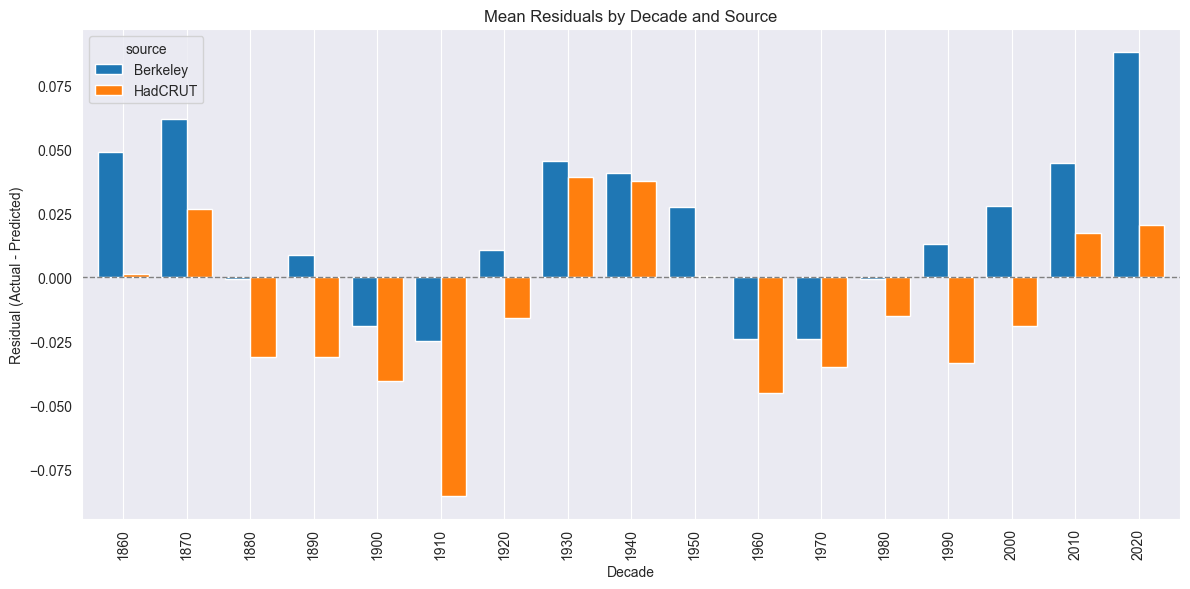

In [239]:
# Compute mean residuals by decade and source
merged_df["Residual"] = merged_df["y"] - merged_df["ModelAvg"]
merged_df["Decade"] = (merged_df["Year"] // 10) * 10
residual_summary = merged_df.groupby(["Decade", "source"])["Residual"].mean().unstack()

# Plot grouped bar chart
residual_summary.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Mean Residuals by Decade and Source")
plt.ylabel("Residual (Actual - Predicted)")
plt.xlabel("Decade")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [240]:
print("\nSample comparison of actual vs ensemble:")
print(merged_df[["Year", "y", "ModelAvg"]].tail(10))



Sample comparison of actual vs ensemble:
     Year         y  ModelAvg
320  2020  1.163580  1.097278
321  2020  1.207310  1.061227
322  2021  0.880456  1.016195
323  2021  0.962261  0.990190
324  2022  0.992347  1.026139
325  2022  1.055142  1.051524
326  2023  1.251474  1.191965
327  2023  1.295005  1.189939
328  2024  1.401703  1.187463
329  2024  1.330020  1.183500



Quantile thresholds (2016–2025):
Low anomaly: ≤ 1.035°C
Moderate anomaly: > 1.035°C and ≤ 1.081°C
High anomaly: > 1.081°C


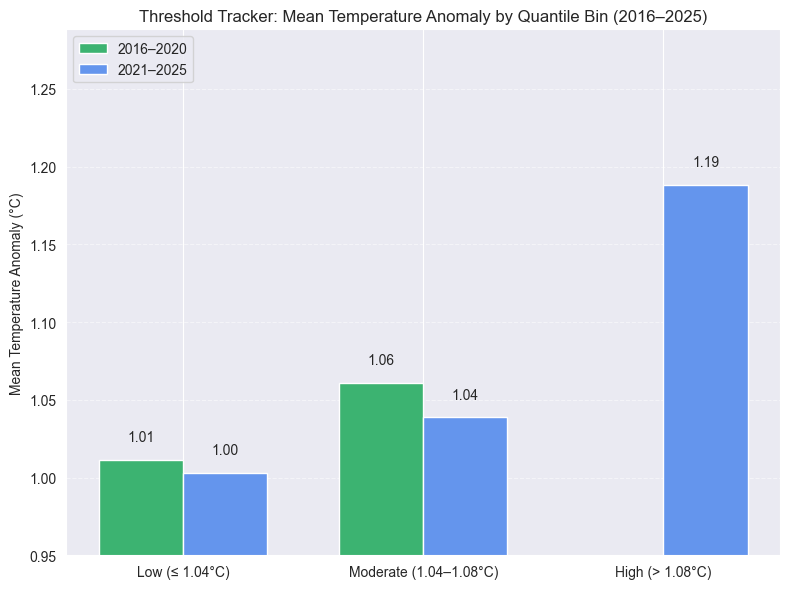

In [241]:
# Step 1: Filter for recent years only
tracker_years = list(range(2016, 2026))
tracker_df = merged_df[merged_df["Year"].isin(tracker_years)]

# Step 2: Compute quantile thresholds
q1 = tracker_df["ModelAvg"].quantile(1/3)
q2 = tracker_df["ModelAvg"].quantile(2/3)

print(f"\nQuantile thresholds (2016–2025):")
print(f"Low anomaly: ≤ {q1:.3f}°C")
print(f"Moderate anomaly: > {q1:.3f}°C and ≤ {q2:.3f}°C")
print(f"High anomaly: > {q2:.3f}°C")

# Step 3: Classify each year
def classify_quantile(value):
    if value <= q1:
        return "Low anomaly"
    elif value <= q2:
        return "Moderate anomaly"
    else:
        return "High anomaly"

annual_df = tracker_df.groupby("Year")[["ModelAvg"]].mean().reset_index()
annual_df["QuantileRange"] = annual_df["ModelAvg"].apply(classify_quantile)

# Step 4: Define windows
prior_years = list(range(2016, 2021))
recent_years = list(range(2021, 2026))

# Step 5: Compute mean anomaly per bin per window
def mean_temp_by_bin(df, years):
    subset = df[df["Year"].isin(years)]
    return subset.groupby("QuantileRange")["ModelAvg"].mean().reindex(
        ["Low anomaly", "Moderate anomaly", "High anomaly"], fill_value=np.nan
    )

prior_means = mean_temp_by_bin(annual_df, prior_years)
recent_means = mean_temp_by_bin(annual_df, recent_years)

# Step 6: Plot bar chart with soft green and blue, adjusted y-axis
labels = [
    f"Low (≤ {q1:.2f}°C)",
    f"Moderate ({q1:.2f}–{q2:.2f}°C)",
    f"High (> {q2:.2f}°C)"
]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, prior_means.values, width, color="mediumseagreen", label="2016–2020")
plt.bar(x + width/2, recent_means.values, width, color="cornflowerblue", label="2021–2025")

# Annotate values
for i in range(len(labels)):
    if not np.isnan(prior_means.values[i]):
        plt.text(x[i] - width/2, prior_means.values[i] + 0.01, f"{prior_means.values[i]:.2f}", ha="center", va="bottom")
    if not np.isnan(recent_means.values[i]):
        plt.text(x[i] + width/2, recent_means.values[i] + 0.01, f"{recent_means.values[i]:.2f}", ha="center", va="bottom")

plt.xticks(x, labels)
plt.title("Threshold Tracker: Mean Temperature Anomaly by Quantile Bin (2016–2025)")
plt.ylabel("Mean Temperature Anomaly (°C)")
plt.ylim(0.95, max(recent_means.max(), prior_means.max()) + 0.1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


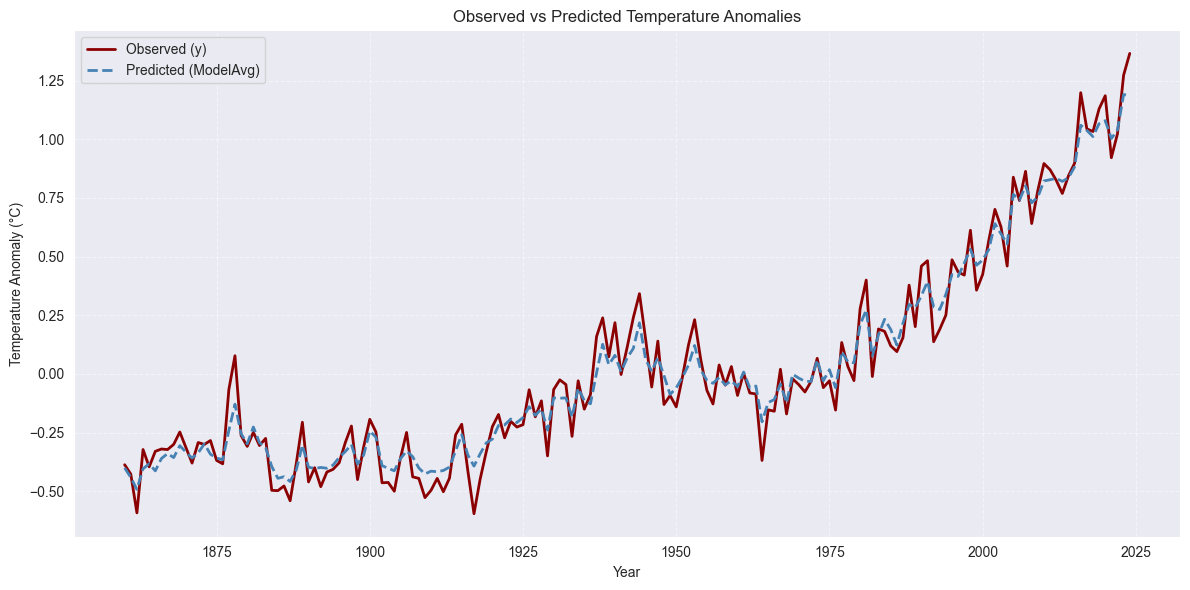

In [242]:
# Step 1: Aggregate by year
compare_df = merged_df.groupby("Year")[["y", "ModelAvg"]].mean().reset_index()

# Step 2: Plot observed vs predicted
plt.figure(figsize=(12, 6))
plt.plot(compare_df["Year"], compare_df["y"], label="Observed (y)", color="darkred", linewidth=2)
plt.plot(compare_df["Year"], compare_df["ModelAvg"], label="Predicted (ModelAvg)", color="steelblue", linewidth=2, linestyle="--")

# Step 3: Final formatting
plt.title("Observed vs Predicted Temperature Anomalies")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


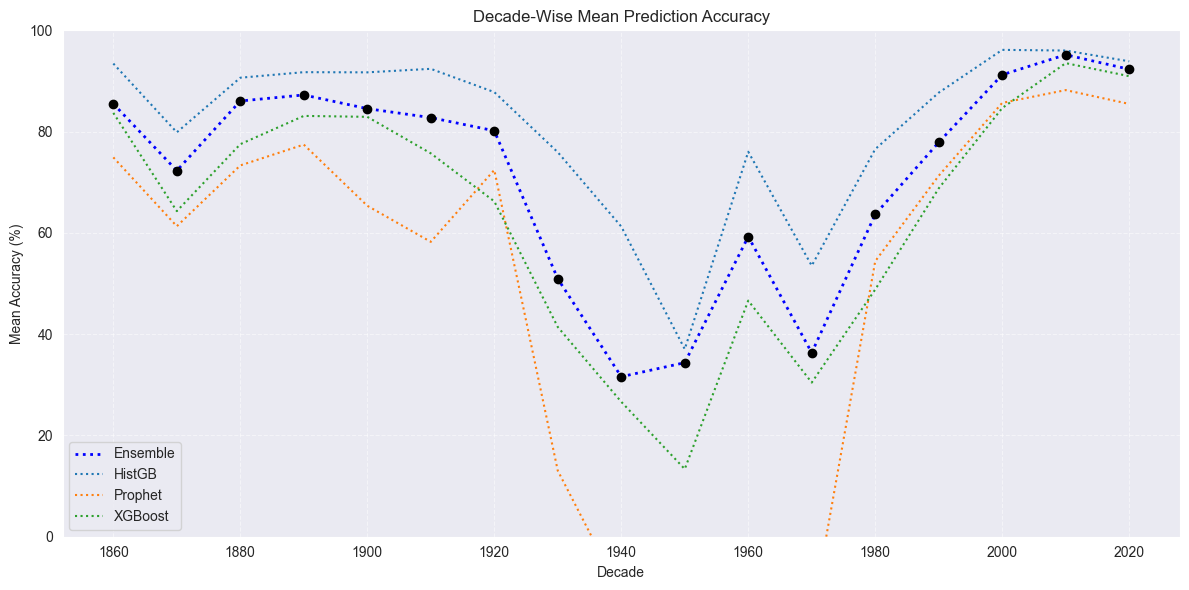

In [246]:
# Step 1: Create decade column
merged_df["Decade"] = (merged_df["Year"] // 10) * 10

# Step 2: Accuracy function (stable)
def compute_accuracy(pred, actual):
    return 100 * (1 - np.abs(pred - actual) / np.maximum(np.abs(actual), np.abs(pred)))

# Step 3: Define models to compare
model_columns = {
    "HistGB_Predicted": "HistGB",
    "RF_Predicted": "Random Forest",
    "Prophet_Predicted": "Prophet",
    "XGB_CV": "XGBoost",
    "ModelAvg": "Ensemble"
}

# Step 4: Compute decade-wise accuracy for each model
def get_decade_accuracy(model_name):
    df = merged_df.copy()
    df["Accuracy"] = compute_accuracy(df[model_name], df["y"])
    return df.groupby("Decade")["Accuracy"].mean().reset_index()

# Step 5: Plot selected models
plt.figure(figsize=(12, 6))

# Uncomment the models you want to show
# Example: comment out lines to hide specific models

# Plot Ensemble
data = get_decade_accuracy("ModelAvg")
plt.plot(data["Decade"], data["Accuracy"], linestyle=":", color="blue", linewidth=2, label="Ensemble")
plt.scatter(data["Decade"], data["Accuracy"], color="black", zorder=5)

# Plot HistGB
data = get_decade_accuracy("HistGB_Predicted")
plt.plot(data["Decade"], data["Accuracy"], linestyle=":", label="HistGB")

# Plot Random Forest
data = get_decade_accuracy("RF_Predicted")
# plt.plot(data["Decade"], data["Accuracy"], linestyle=":", label="Random Forest")

# Plot Prophet
data = get_decade_accuracy("Prophet_Predicted")
plt.plot(data["Decade"], data["Accuracy"], linestyle=":", label="Prophet")

# Plot XGBoost
data = get_decade_accuracy("XGB_CV")
plt.plot(data["Decade"], data["Accuracy"], linestyle=":", label="XGBoost")

# Step 6: Final formatting
plt.title("Decade-Wise Mean Prediction Accuracy")
plt.xlabel("Decade")
plt.ylabel("Mean Accuracy (%)")
plt.ylim(0, 100)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
